In [111]:
import pandas as pd
import numpy as np
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from sklearn.metrics import accuracy_score

from lxml import etree
import xml.etree.ElementTree as ET
import re

In [105]:
#Class for activity

class Activity(object):
    """This is for any activity of exercise. It may be a run or a cycle.

    Attributes:
        Heart Rate: 
        Speed:
        Gradient:
    """

    def __init__(self, filename):
        """Return a activity object"""
        self.heart = []
        self.speed = []
        self.elevation  = []
        self.gradient = []
        
        gpx_file = open('{}'.format(filename), 'r') 
        gpx = gpxpy.parse(gpx_file)
        self.gpx = gpx
        
        tree = ET.parse(filename)
        root = tree.getroot()
        string = ET.tostring(root[1])
        heart_rate = re.findall('hr>(.*?)</ns' ,string)
        heart_array = np.asarray(heart_rate)
        heart_array = heart_array[:-1]
        heart_array = heart_array.astype(np.float)
        self.heart = heart_array
    
        speed =[]
        for track in gpx.tracks:
            for segment in track.segments:
                for point_no, point in enumerate(segment.points):
                    if point.speed != None:
                        print "Speed=", point.speed
                    elif point_no > 0:
                        #print "Calculated speed=", point.speed_between(segment.points[point_no - 1])
                        speed.append(point.speed_between(segment.points[point_no - 1]))
        speed_array = np.asarray(speed)
        self.speed = speed_array
        
        elevation = []  
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    elevation.append(point.elevation)
        self.elevation = elevation
        
        gradient = []
        for value in range(1,len(elevation)):
            gradient.append(elevation[value]-elevation[value-1])
        gradient_array = np.asarray(gradient)    
        self.gradient = gradient_array
        
    def plot_basic(self):
        plt.plot(self.gradient, 'ro')
        plt.show()
        plt.plot(self.speed, 'bo')
        plt.show()
        plt.plot(self.heart, 'go')
        plt.show()
        
    def average_preceeding_speed(self, n):
        ret = np.cumsum(self.speed, dtype=float)
        moving_average = np.empty([len(ret)])
        moving_average[0] = ret[0]
        for i in range(len(ret)):
            if( i <= n and i > 0 ):
                moving_average[i] = ret[i]/(i+1)
            if(i > n):
                z= i - n
                moving_average[i]=(ret[i]-ret[z])/n
        return moving_average 
    
    def average_preceeding_gradient(self, n):
        ret = np.cumsum(self.gradient, dtype=float)
        moving_average = np.empty([len(ret)])
        moving_average[0] = ret[0]
        for i in range(len(ret)):
            if( i <= n and i > 0 ):
                moving_average[i] = ret[i]/(i+1)
            if(i > n):
                z= i - n
                moving_average[i]=(ret[i]-ret[z])/n
        return moving_average 
    


In [106]:
cycle_one = Activity('Evening_Ride_heart_rate.gpx')

In [108]:
cycle_one.average_preceeding_gradient(120)

array([ 0.4       ,  0.25      ,  0.16666667, ...,  0.00833333,
        0.00666667,  0.00583333])

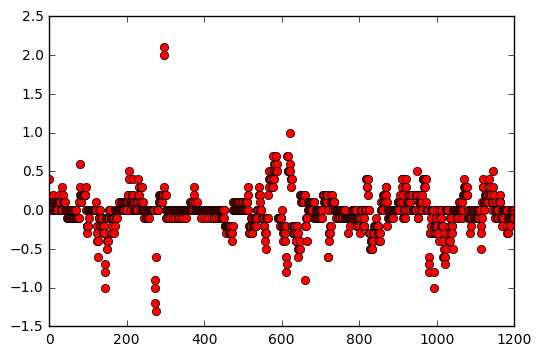

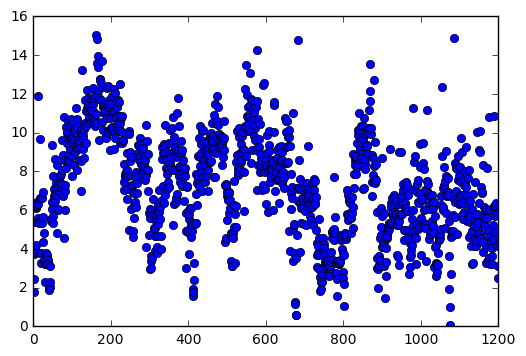

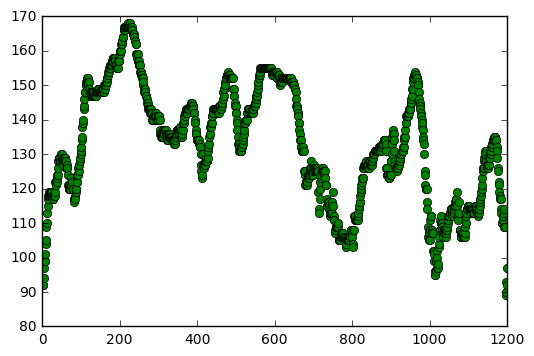

In [13]:
cycle_one.plot_basic()

In [14]:
def Load_gpx(filename):
    gpx_file = open('{}.gpx'.format(filename), 'r') 
    gpx = gpxpy.parse(gpx_file)
    return gpx

In [15]:
#gpx = Load_gpx('Lunch_Run')
#gpx = Load_gpx('Afternoon_Ride')
#gpx = Load_gpx('Evening_Ride')
gpx = Load_gpx('Evening_Ride_heart_rate')

In [16]:
tree = ET.parse('Evening_Ride_heart_rate.gpx')
root = tree.getroot()
root[1]
string = ET.tostring(root[1])
import re
heart_rate = re.findall('hr>(.*?)</ns' ,string)
len(heart_rate)

1202

In [17]:
def Extract_speed(gpx):
    speed = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point_no, point in enumerate(segment.points):
                if point.speed != None:
                    print "Speed=", point.speed
                elif point_no > 0:
                    #print "Calculated speed=", point.speed_between(segment.points[point_no - 1])
                    speed.append(point.speed_between(segment.points[point_no - 1]))
    return speed
    
def Extract_elevation(gpx):    
    elevation = []
    for track in gpx.tracks:
        for segment in track.segments:
            
            for point in segment.points:
                #print(segment.points)
                elevation.append(point.elevation)
    #print segment.points
    return elevation


#def Extract_heart(gpx):
 #   heart = []
  #  for track in gpx.tracks:
   #     for segment in track.segments:
    #        for point in segment.points:
     #           for extension in point.extensions:
      #              for TrackPointExtension in extension.'gpxtpx:TrackPointExtensions':
       #                 #print extension.TrackPointExtensions
        #                    print point.extensions
         #               #heart.append(extension.hr)
    
   #return extension.

In [18]:
# Input data for the machine learning
speed = Extract_speed(gpx)
elevation = Extract_elevation(gpx)
#heart = Extract_heart(gpx)
len(elevation)
len(speed)

1201

In [19]:
# take elevation and manipulate
gradient = []
for value in range(1,len(elevation)):
    gradient.append(elevation[value]-elevation[value-1])

#Test and Train
speed_array = np.asarray(speed)
gradient_array = np.asarray(gradient)
heart_array = np.asarray(heart_rate)
heart_array = heart_array[:-1]

speed_array
heart_array = heart_array.astype(np.float)

In [22]:
# Feature engineering. Create more features based on the proceeding 5 minutes
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

gradient_average_30 = moving_average(gradient_array, 30)
gradient_average_120 = moving_average(gradient_array, 120)
gradient_average_240 = moving_average(gradient_array, 240)

speed_average_30 = moving_average(speed_array, 30)
speed_average_120  = moving_average(speed_array, 120)
speed_average_240 = moving_average(speed_array, 240)

In [86]:
#Average for the preceeding n number of seconds. 
def average_preceeding(a,n):
    ret = np.cumsum(speed_array, dtype=float)
    moving_average = np.empty([len(ret)])
    moving_average[0] = ret[0]
    for i in range(len(ret)):
        if( i <= n and i > 0 ):
            moving_average[i] = ret[i]/(i+1)
            #print ret[i]
        if(i > n):
            z= i - n
            moving_average[i]=(ret[i]-ret[z])/n
    return moving_average       

In [89]:
speed_before_30 = average_preceeding(speed_array, 30)
speed_before_60 = average_preceeding(speed_array, 60)
speed_before_120 = average_preceeding(speed_array, 120)
speed_before_300 = average_preceeding(speed_array, 300)


In [110]:
#plt.plot(speed_before_30, 'ro')
#plt.show()
#plt.plot(speed_before_60, 'ro')
#plt.show()
#plt.plot(speed_before_120, 'ro')
#plt.show()
#plt.plot(speed_before_300, 'ro')
#plt.show()

In [30]:
half = len(heart_array)/2
heart_input_train = heart_array[:-half]
speed = speed_array[:-half]
speed_test = speed_array[-half:]
gradient_test= gradient_array[-half:]
actual_heart = heart_array[-half:]   
gradient_train = gradient_array[:-half]

In [31]:

Train_speed = speed.reshape(-1,1)
Train_heart =heart_input_train.reshape(-1,1)
Train_gradient = gradient_train.reshape(-1,1)
Test_speed = speed_test.reshape(-1,1)
Actual_heart = actual_heart.reshape(-1,1)
Test_gradient = gradient_test.reshape(-1,1)

In [32]:
#plt.plot(speed_array[-half:]  , heart_rate[-half:], 'bo')
#plt.plot(gradient_array[-half:]  , heart_rate[-half:], 'ro')
#plt.show()

In [33]:
# Create linear regression object
reg = linear_model.LinearRegression()
reg.fit(Train_speed, Train_heart)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
# Make predictions using the testing set
heart_rate_predicted_regression = reg.predict(Test_speed)
#heart_rate_predicted_regression

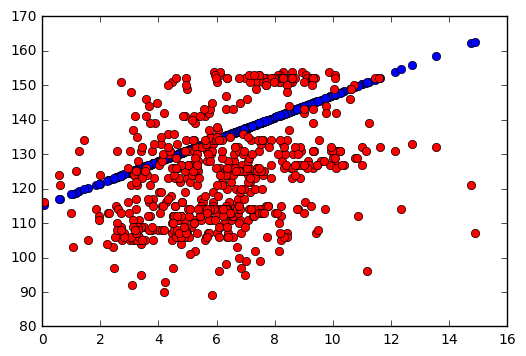

In [35]:
plt.plot(Test_speed ,heart_rate_predicted_regression, 'bo')
plt.plot(Test_speed ,Actual_heart, 'ro')
plt.show()

In [36]:
# The coefficients
#print('Coefficients: \n', reg.coef_)

reg.coef_
reg.intercept_
# The mean squared error
#print("Mean squared error: %.2f"
#      % mean_squared_error(grad2, prediction_grad))
# Explained variance score: 1 is perfect prediction
#print('Variance score: %.2f' % r2_score(grad2, prediction_grad))

reg.score(Train_speed, Train_heart)

# should i be getting it between 0 and 1. get rid of the variation. can't remember what it's  called. 

0.33831151743827148

In [37]:
reg.intercept_

array([ 115.15825388])

In [38]:
# Now do it for the gradient instead of the speed
# Create linear regression object
reg_grad = linear_model.LinearRegression()
reg_grad.fit(Train_gradient, Train_heart)
heart_rate_predicted_on_gradient = reg_grad.predict(Test_gradient)

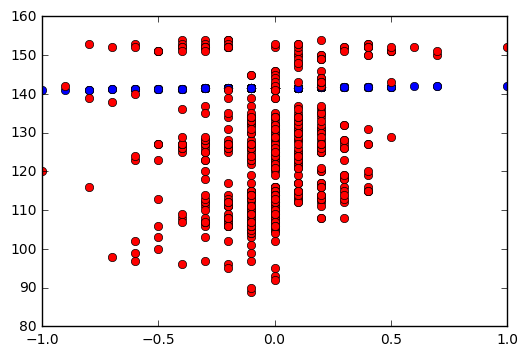

In [39]:
plt.plot(Test_gradient ,heart_rate_predicted_on_gradient, 'bo')
plt.plot(Test_gradient ,Actual_heart, 'ro')
plt.show()

In [40]:
reg_grad.score(Train_gradient, Train_heart)

9.2615201319645735e-05

In [41]:
#Lets see if we can do a multiple linear regression that basically takes in both variables. 
# combine the speed and gradient data. 
combined_data= np.array([speed_array[0],gradient_array[0]])

for i in range(1,len(speed_array)):
    b= [speed_array[i], gradient_array[i]]
    combined_data = np.vstack((combined_data ,b)) 

half = len(combined_data)/2
    
train_input_data = combined_data[:-half]
test_input_data = combined_data[-half:]    

In [42]:
len(train_input_data)
len(Train_heart)
train_input_data.shape
Train_heart.shape

(601L, 1L)

In [43]:
reg_two_linear = linear_model.LinearRegression()
reg_two_linear.fit(train_input_data, Train_heart)
heart_rate_predicted_on_both = reg_two_linear.predict(test_input_data)

In [44]:
fig = plt.figure(figsize=(6, 6))
plt.plot(Test_speed ,heart_rate_predicted_on_both, 'bo')
plt.plot(Test_speed ,Actual_heart, 'ro')
plt.xlabel("speed m/s")
plt.ylabel("Heart Rate (bpm)")
plt.show

fig.savefig("example_fig_strave.png")

In [45]:
reg_two_linear.score(train_input_data, Train_heart)

0.34079196283714452

In [46]:
# a very tiny improvement from using both. Now i've a number of options that include using the engineered features and also none linear fits. 

In [47]:
#SVR time
from sklearn.svm import SVR
clf = SVR(kernel = 'poly', epsilon=0.2)
#clf.fit(train_input_data, Train_heart) 
clf.fit(Train_speed, Train_heart)

C:\Users\Andrew\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [48]:
SVR_pre = clf.predict(Test_speed)

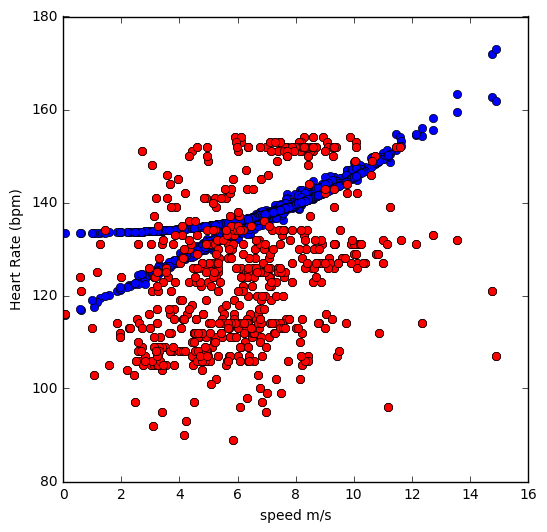

0.26571433446638115

In [49]:
plt.plot(Test_speed ,SVR_pre, 'bo')
plt.plot(Test_speed ,Actual_heart, 'ro')
plt.show()
clf.score(Train_speed, Train_heart)

In [50]:
# what we could do is create this neatly to run through some of the different options. 
# now to get the SVR to take in both speed and gradient. 

In [51]:
clf = SVR(kernel = 'poly', epsilon=0.2)
#clf.fit(train_input_data, Train_heart) 
clf.fit(train_input_data, Train_heart)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [52]:
SVR_pre = clf.predict(test_input_data)

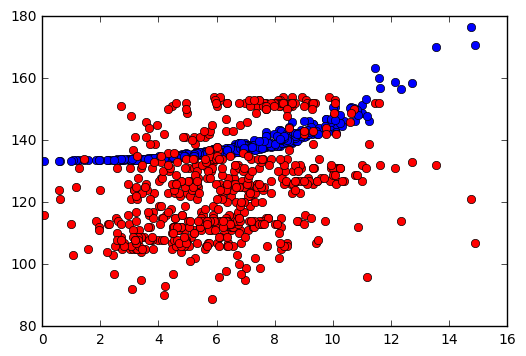

0.27359473053687056

In [53]:
plt.plot(Test_speed ,SVR_pre, 'bo')
plt.plot(Test_speed ,Actual_heart, 'ro')
plt.show()
clf.score(train_input_data, Train_heart)

In [42]:
# again small improvement . now i need to add in the engineered features. 